In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
indir="/content/drive/My Drive/Colab Notebooks/data/"

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/My Drive/LSM_Segmentation_Dataset/PHH3-Cells'
TEST_DIR = os.path.join(DATA_DIR, 'Test')
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
VAL_DIR = os.path.join(DATA_DIR, 'Validation')

y_train_dir = os.path.join(TRAIN_DIR, 'Mask')
x_train_dir = os.path.join(TRAIN_DIR, 'Original')

y_valid_dir = os.path.join(VAL_DIR, 'Mask')
x_valid_dir = os.path.join(VAL_DIR, 'Original')

y_test_dir = os.path.join(TEST_DIR, 'Mask')
x_test_dir = os.path.join(TEST_DIR, 'Original')

In [ ]:
# Get class names
class_names = ['cell', 'background']
# Get class RGB values
class_rgb_values = [[255, 255, 255], [0, 0, 0]]

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['cell', 'background']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['cell', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
original_images = []
image_paths = [os.path.join(x_train_dir, image_id) for image_id in sorted(os.listdir(x_train_dir))]
for i in image_paths:
  image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
  original_images.append(image)

In [ ]:
test_original_images = []
image_paths = [os.path.join(x_test_dir, image_id) for image_id in sorted(os.listdir(x_test_dir))]
for i in image_paths:
  image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
  test_original_images.append(image)

In [ ]:
class CellDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        image = cv2.Canny(image, 100, 200)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
            
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

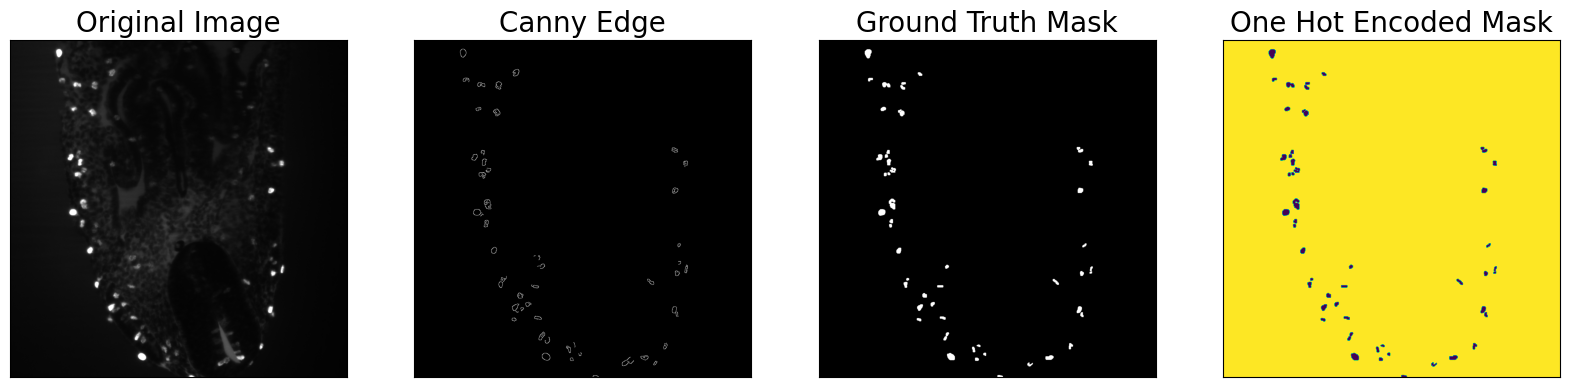

In [ ]:
dataset = CellDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]
original = original_images[2]

visualize(
    original_image = original,
    canny_edge = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
def get_training_augmentation():
    train_transform = [    
        album.Resize(256, 256),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        
        



    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(256, 256),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def canny(img):
  return cv2.Canny(img, 50, 150)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

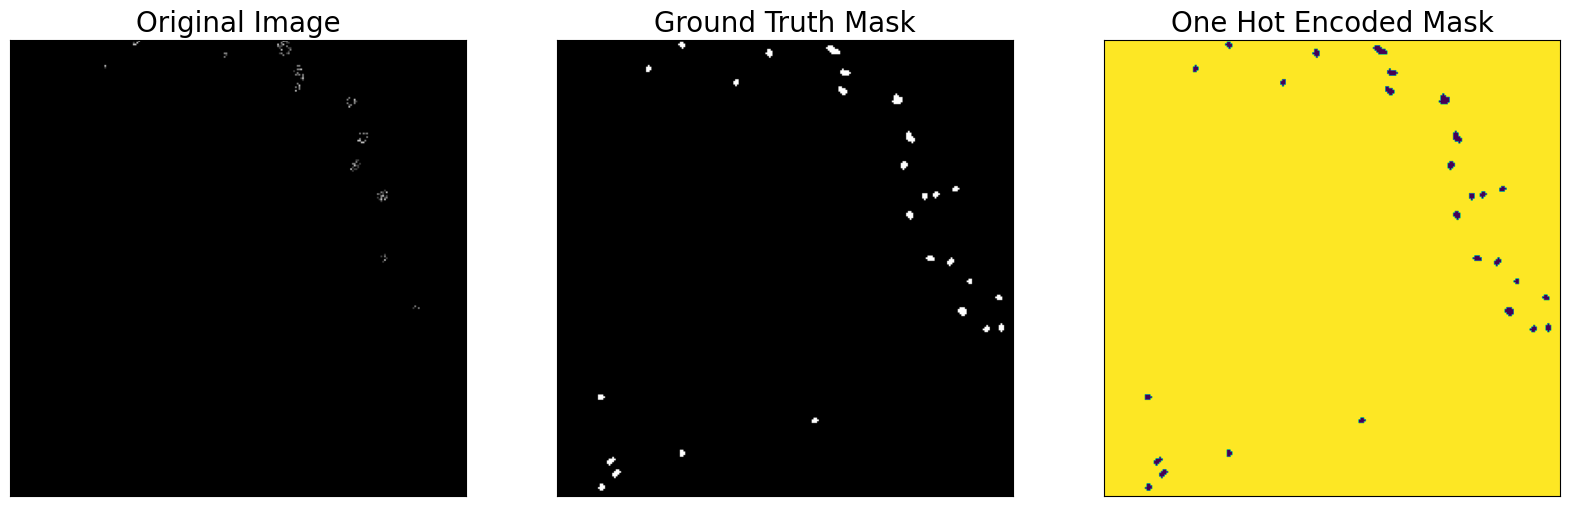

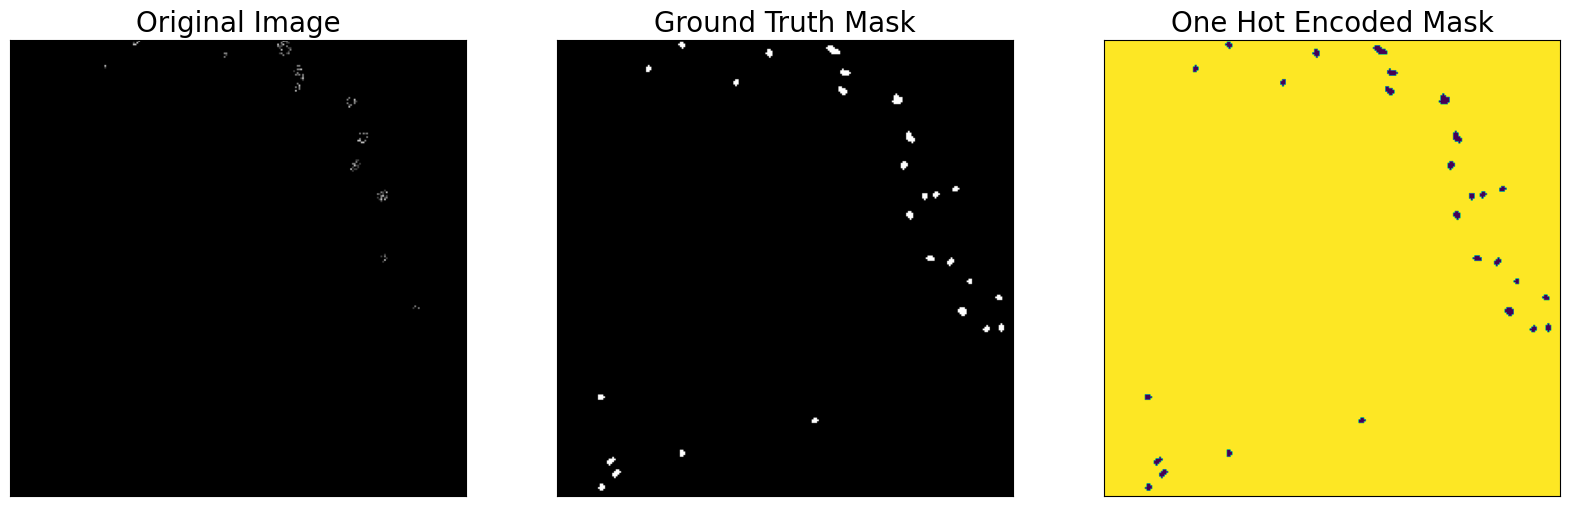

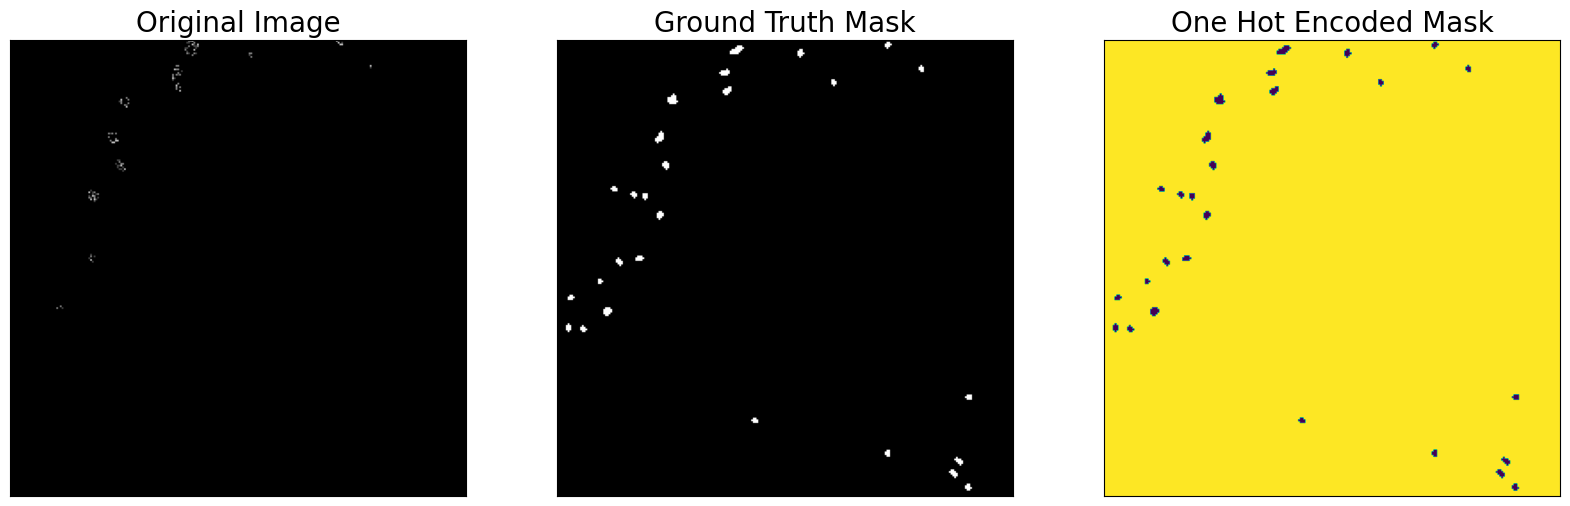

In [ ]:
augmented_dataset = CellDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [ ]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def forward(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand


In [ ]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.float())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss.detach().cpu().numpy()) if phase=='train' else valid_loss.append(epoch_loss.detach().cpu().numpy())
            train_acc.append(epoch_acc.detach().cpu().numpy()) if phase=='train' else valid_acc.append(epoch_acc.detach().cpu().numpy())

            if epoch_acc > best_acc:
              best_acc = epoch_acc
              torch.save(model, './best_model.pth')
              print('Model saved!')


    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss, train_acc, valid_acc   




In [ ]:
# Get train and val dataset instances
train_dataset = CellDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = CellDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
unet = UNET(3, 2)

In [ ]:
import segmentation_models_pytorch.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
loss_fn = smp.utils.losses.DiceLoss()
opt = torch.optim.Adam(unet.parameters(), lr = 0.0005)
train_loss, valid_loss, train_acc, valid_acc = train(unet, train_loader, valid_loader, loss_fn, opt, smp.utils.metrics.IoU(threshold=0.5), epochs = 50)

Epoch 0/49
----------
train Loss: 0.9588 Acc: 0.008728968910872936
Model saved!
Current step: 10  Loss: 0.8564575910568237  Acc: 0.00434221513569355  AllocMem (Mb): 31.61572265625
Current step: 20  Loss: 0.8564848899841309  Acc: 0.002830102574080229  AllocMem (Mb): 31.61572265625
valid Loss: 0.8595 Acc: 0.005060103256255388
Epoch 1/49
----------
train Loss: 0.9322 Acc: 0.007193443831056356
Current step: 10  Loss: 0.837124228477478  Acc: 0.004659704864025116  AllocMem (Mb): 31.6162109375
Current step: 20  Loss: 0.8374444246292114  Acc: 0.0029350933618843555  AllocMem (Mb): 31.6162109375
valid Loss: 0.8398 Acc: 0.005260182078927755
Epoch 2/49
----------
train Loss: 0.9151 Acc: 0.006939912214875221
Current step: 10  Loss: 0.8201265335083008  Acc: 0.004735523834824562  AllocMem (Mb): 31.6162109375
Current step: 20  Loss: 0.8208107948303223  Acc: 0.0029660051222890615  AllocMem (Mb): 31.6162109375
valid Loss: 0.8229 Acc: 0.005305849015712738
Epoch 3/49
----------
train Loss: 0.8937 Acc: 0.0

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth')
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth')
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


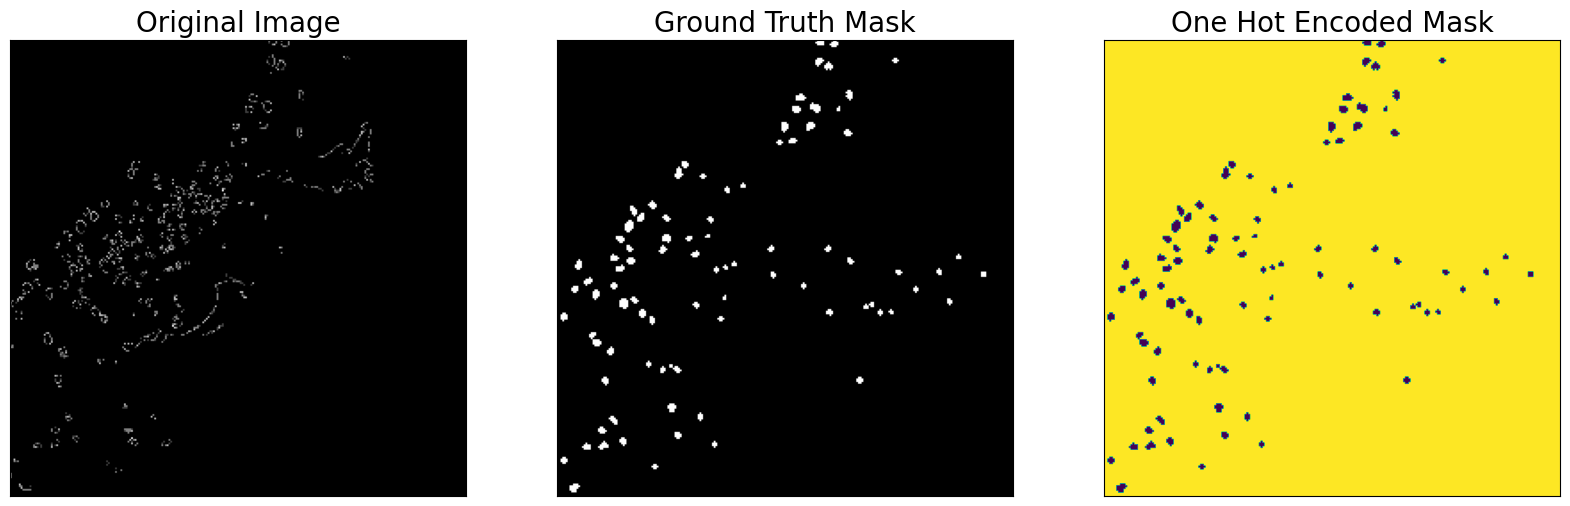

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = CellDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = CellDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 256*256 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for idx in range(len(test_dataset)):

    #random_idx = random.randint(0, len(test_dataset)-1)
    random_idx = idx
    image, gt_mask = test_dataset[random_idx]
    image_vis = crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('cell')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    visualize(
        original_image = test_original_images[random_idx],
        canny_edge = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

In [ ]:
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

test_epoch = smp.utils.train.ValidEpoch(
    unet,
    loss=smp.utils.losses.DiceLoss(), 
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)


valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 49/49 [00:07<00:00,  6.94it/s, dice_loss - -0.439, iou_score - 0.3294]
Evaluation on Test Data: 
Mean IoU Score: 0.3294
Mean Dice Loss: -0.4390


In [ ]:
train_loss_df = pd.DataFrame(train_loss)
valid_loss_df = pd.DataFrame(valid_loss)
train_acc_df = pd.DataFrame(train_acc)
valid_acc_df = pd.DataFrame(valid_acc)

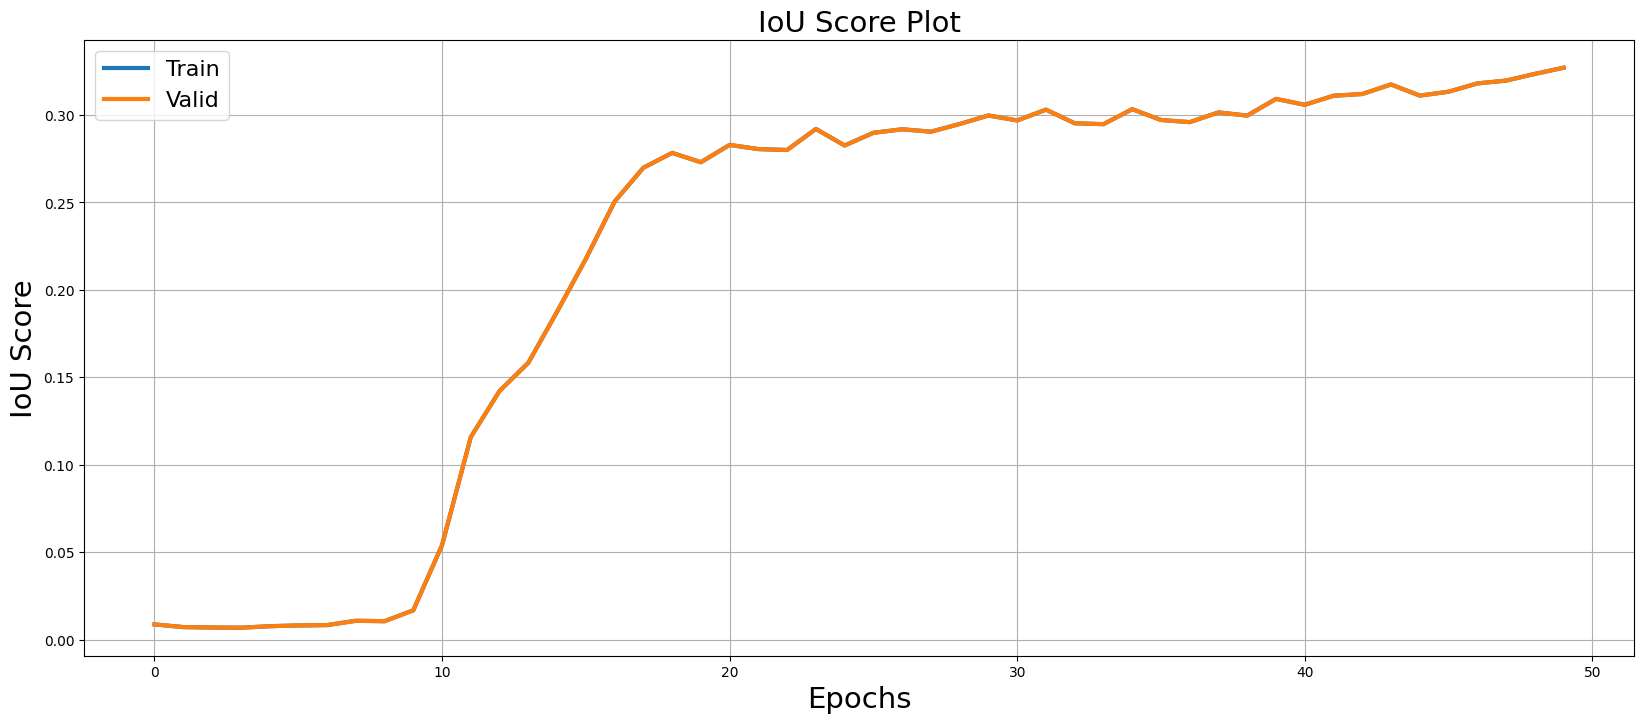

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_acc_df.index, train_acc_df, lw=3, label = 'Train')
plt.plot(train_acc_df.index, train_acc_df, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

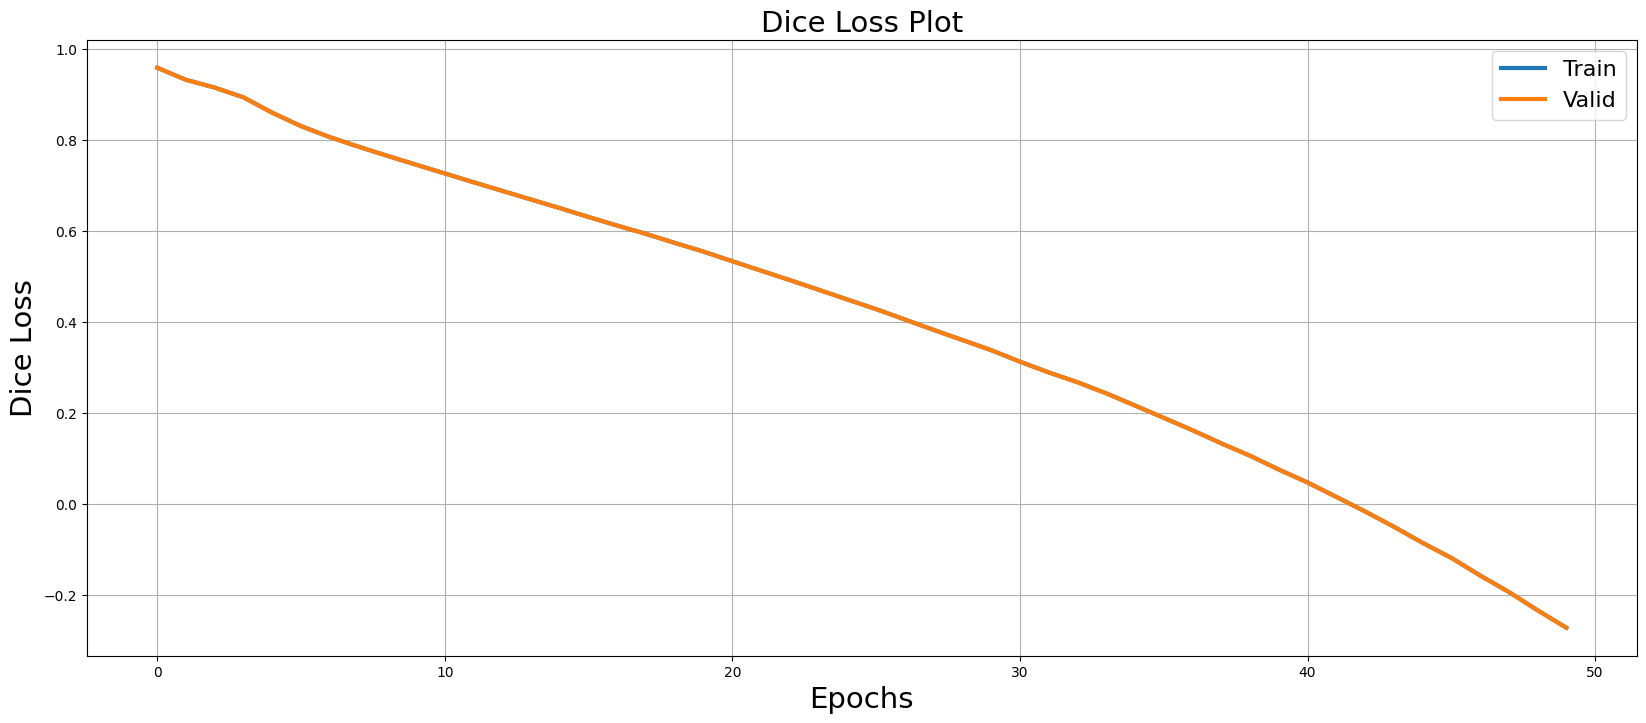

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_loss_df.index, train_loss_df, lw=3, label = 'Train')
plt.plot(train_loss_df.index, train_loss_df, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()